In [4]:
import time
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import transforms
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

In [7]:
class Images(Dataset):
    def __init__(self, images_path, monet_path, transforms):
        self.images = []
        self.monet = []
        self.main_dir = '../input/gan-getting-started/'
        for f in os.listdir(self.main_dir + images_path):
            if f.endswith('.jpg'):
                    self.images.append(self.main_dir + images_path + f)
        for f in os.listdir(self.main_dir + monet_path):
            if f.endswith('.jpg'):
                    self.monet.append(self.main_dir + monet_path + f)
        
        
        self.transforms = transforms
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        photo = self.images[idx]
        monet = self.monet[np.random.randint(1, len(self.monet))]
        return [self.transforms(Image.open(photo)), self.transforms(Image.open(monet))]

photos_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

ImagesDataset = Images('photo_jpg/', 'monet_jpg/', photos_transforms)
#MonetDataset = Images('monet_jpg/', photos_transforms)

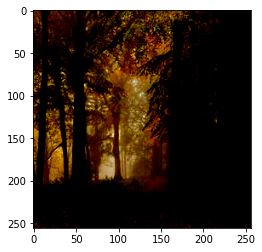

In [8]:
plt.imshow((ImagesDataset[0][0]).permute(1, 2, 0))

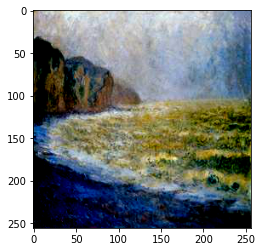

In [9]:
plt.imshow((ImagesDataset[0][1]).permute(1, 2, 0))

In [10]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [11]:
class ResidualBlock(nn.Module):

    def __init__(self, size):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(size, size, kernel_size=3, padding=1, padding_mode='reflect'),
            nn.BatchNorm2d(size),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(size, size, kernel_size=3, padding=1, padding_mode='reflect'),
            nn.BatchNorm2d(size),
        )

    def forward(self, x):
        return nn.ReLU()(x + self.block(x))

Согласно 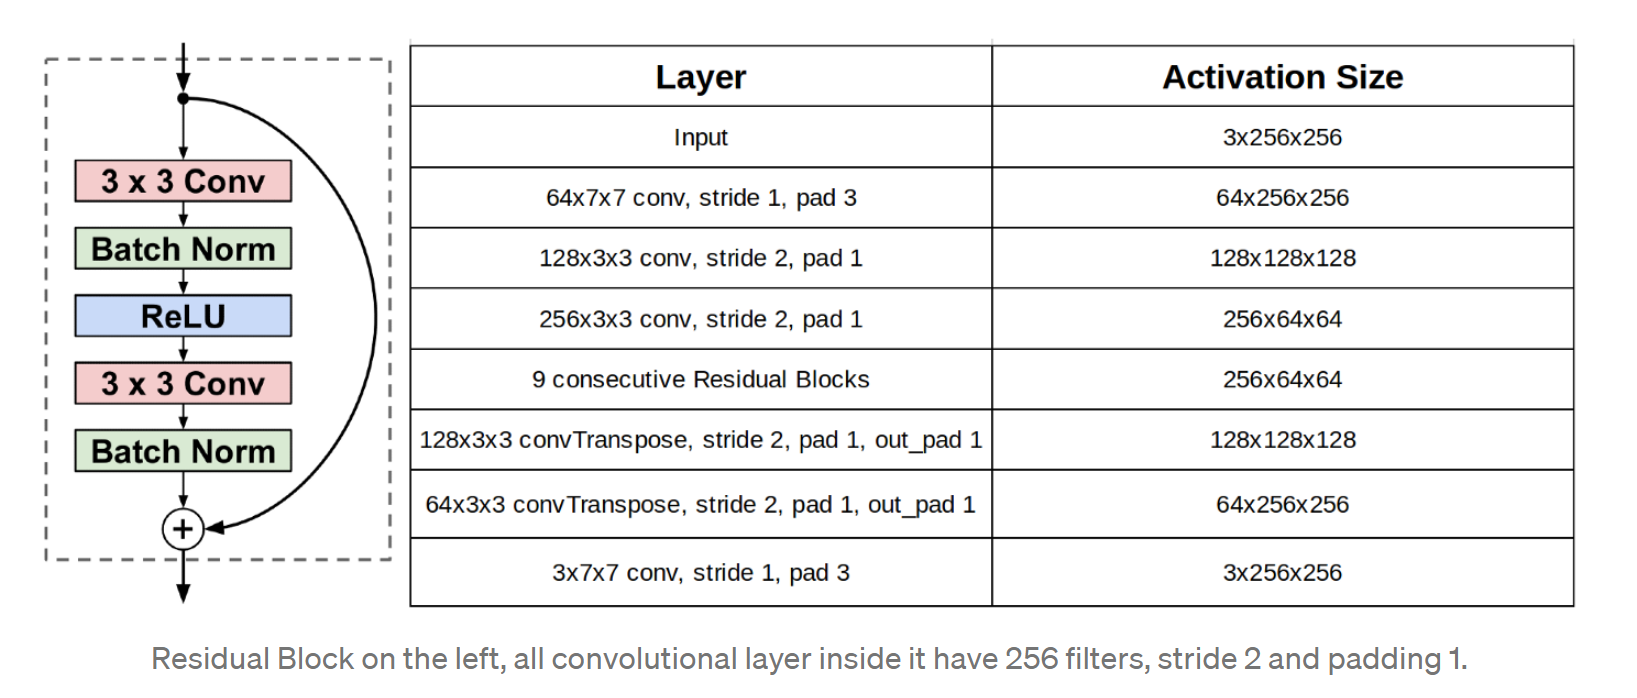


In [12]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.encode = [
            # input = [3, 256, 256]
            nn.Conv2d(3, 64, 7, 1, 3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            
            nn.Conv2d(64, 128, 3, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            
            nn.Conv2d(128, 256, 3, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True)
        ]
        self.encode.extend([ResidualBlock(256)] * 9)
        
        self.encode.extend([
            nn.ConvTranspose2d(256, 128, 3, 2, 1, output_padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
        
            nn.ConvTranspose2d(128, 64, 3, 2, 1, output_padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            
            nn.Conv2d(64, 3, 7, 1, 3, bias=False),
            nn.Tanh()
        
        ])
        
        self.encode = nn.Sequential(*self.encode)
        
    def forward(self, x):
        return self.encode(x)

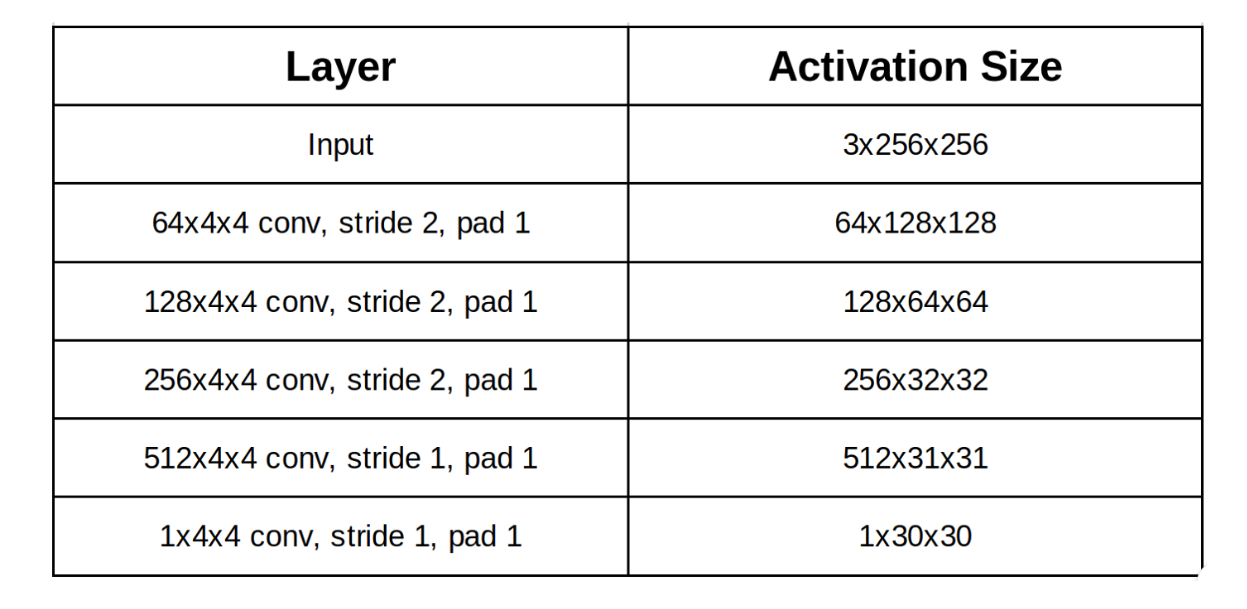


In [13]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.decode = nn.Sequential( 
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            
            nn.Conv2d(256, 512, 4, 1, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            
            nn.Conv2d(512, 1, 4, 1, 1, bias=False),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        
    def forward(self,x):
        return self.decode(x)

In [14]:
class ReplayBuffer:
    def __init__(self, max_size = 50):
        self.max_size = max_size
        self.data = []
        
    def push_and_pop(self, data):
        data = data.detach()
        res = []
        for element in data:
            if len(self.data) < self.max_size:
                self.data.append(element)
                res.append(element)
            else:
                if np.random.uniform(0, 1) > 0.5:
                    i = np.random.randint(0, self.max_size - 1)
                    res.append(self.data[i].clone())
                    self.data[i] = element
                else:
                    res.append(element)
        return torch.stack(res)

In [15]:
G_1, G_2 = Generator().to(device), Generator().to(device)
D_1, D_2 = Discriminator().to(device), Discriminator().to(device)

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


G_1.apply(weights_init)
G_2.apply(weights_init)
D_1.apply(weights_init)
D_2.apply(weights_init)

In [ ]:
optimizer_G1, optimizer_G2 = torch.optim.NAdam(G_1.parameters()), torch.optim.NAdam(G_2.parameters())
optimizer_D1, optimizer_D2 = torch.optim.Adadelta(D_1.parameters()), torch.optim.Adadelta(D_2.parameters())

scheduler_G1 = torch.optim.lr_scheduler.MultiStepLR(optimizer_G1, milestones=[5])
scheduler_G2 = torch.optim.lr_scheduler.MultiStepLR(optimizer_G2, milestones=[5])

scheduler_D1 = torch.optim.lr_scheduler.MultiStepLR(optimizer_D1, milestones=[5])
scheduler_D2 = torch.optim.lr_scheduler.MultiStepLR(optimizer_D2, milestones=[5])

In [ ]:
cycle_loss = torch.nn.L1Loss().to(device)
identity_loss = torch.nn.L1Loss().to(device)
adversarial_loss = torch.nn.MSELoss().to(device)
lmbd = 10
identity_w = 0.5 * lmbd
cycle_w = 0.1 * lmbd
batch_size = 4
num_epoch = 10

In [ ]:
loader = DataLoader(ImagesDataset, batch_size=batch_size, shuffle=True)
photo_buf = ReplayBuffer()
monet_buf = ReplayBuffer()

In [ ]:
G_losses = []
D_losses = []
iters = 0
best_g = 100
best_d = 100
G_1.train(), G_2.train(), D_1.train(), D_2.train()



for e in range(1, num_epoch):
    for photo, monet in loader:
        
        photo = photo.to(device)
        monet = monet.to(device)
        real_label = torch.ones(photo.size()[0], 1, 30, 30,
                                         device=device, requires_grad=False)
        

        fake_label = torch.zeros(photo.size()[0], 1, 30, 30,
                                           device=device, requires_grad=False)
        
        # GENERATORS
        optimizer_G1.zero_grad()
        optimizer_G2.zero_grad()
        
        identity_loss_photo = identity_loss(G_2(photo), photo) * identity_w
        identity_loss_monet = identity_loss(G_1(monet), monet) * identity_w
        
        fake_photo = G_2(monet)
        #fake_photo_d = D_1(fake_photo)
        #adversarial_loss_2 = adversarial_loss(fake_photo_d, real_label)
        
        adversarial_loss_2 = adversarial_loss(D_1(fake_photo), real_label)
        
        fake_monet = G_1(photo)
        #fake_monet_d = D_2(fake_monet)
        #adversarial_loss_1 = adversarial_loss(fake_monet_d, real_label)
        
        adversarial_loss_1 = adversarial_loss(D_2(fake_monet), real_label)
        
        monet2photo = G_2(fake_monet)
        cycle_loss_p2m2p = cycle_loss(monet2photo, photo) * cycle_w
        
        photo2monet = G_1(fake_photo)
        cycle_loss_m2p2m = cycle_loss(photo2monet, monet) * cycle_w
        
        total_loss = identity_loss_photo + identity_loss_monet + adversarial_loss_1 + adversarial_loss_2 +\
                     cycle_loss_p2m2p + cycle_loss_m2p2m
        
        total_loss.backward()
        optimizer_G1.step()
        optimizer_G2.step() 
        
        G_losses.append(total_loss.item())
        
        # DISCRIMINATORS
        optimizer_D1.zero_grad()
        
        
        loss_real = adversarial_loss(D_1(photo), real_label)
        fake_photo_ = photo_buf.push_and_pop(fake_photo)
        loss_fake = adversarial_loss(D_1(fake_photo_.detach()), fake_label)
    
        loss_D_1 = (loss_real + loss_fake) / 2

        loss_D_1.backward()
        optimizer_D1.step()
        
        optimizer_D2.zero_grad()
        
        loss_real = adversarial_loss(D_2(monet), real_label)
        fake_monet_ = monet_buf.push_and_pop(fake_monet)
        loss_fake = adversarial_loss(D_2(fake_monet_.detach()), fake_label)

        loss_D_2 = (loss_real + loss_fake) / 2

        loss_D_2.backward()
        optimizer_D2.step()

        loss_D = (loss_D_1 + loss_D_2) / 2
        
        D_losses.append(loss_D.item())
                    
        scheduler_G1.step()
        scheduler_G2.step()
        scheduler_D1.step()
        scheduler_D2.step()
        
        if iters % 100 == 0:
            print(f'{e}/{num_epoch}, {iters/len(loader)}')
            print(f'  G loss: {total_loss}')
            print(f'  D loss: {loss_D}')
            print()
            
        if (total_loss < best_g and loss_D < best_d):
            torch.save(G_1.state_dict(), "./G_1.pth")
            torch.save(G_2.state_dict(), "./G_2.pth")
            torch.save(D_1.state_dict(), "./D_1.pth")
            torch.save(D_2.state_dict(), "./D_2.pth")
        iters += 1


In [ ]:
#os.chdir(r'/kaggle/working')
#import IPython
#from IPython.display import FileLink
#FileLink('./G_1.pth')
#FileLink('./G_2.pth')
#FileLink('./D_1.pth')
#FileLink('./D_2.pth')

In [18]:
G_1.load_state_dict(torch.load('../input/myparams/G_1 (3).pth'))
G_2.load_state_dict(torch.load('../input/myparams/G_2 (3).pth'))
D_1.load_state_dict(torch.load('../input/myparams/D_1 (3).pth'))
D_2.load_state_dict(torch.load('../input/myparams/D_2 (3).pth'))

<All keys matched successfully>

In [ ]:
#ImagesDataset[0][0].view(1, 3, 256, 256).size()

In [19]:
unnorm = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.5, 1/0.5, 1/0.5 ]),
                                transforms.Normalize(mean = [ -0.5, -0.5, -0.5 ],
                                                     std = [ 1., 1., 1. ]),
                               ])

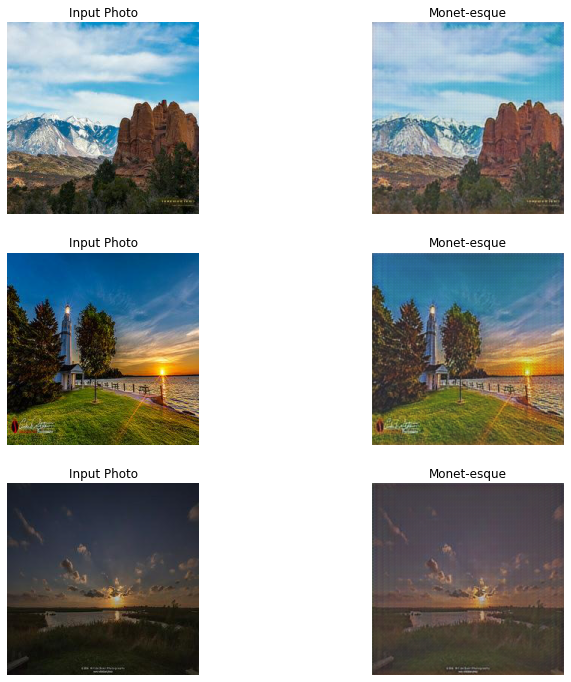

In [20]:
_, ax = plt.subplots(3, 2, figsize=(12, 12))
G_1.eval()
for i, img in enumerate([ImagesDataset[66][0], ImagesDataset[1044][0], ImagesDataset[35][0]]):
    prediction = G_1(img.view(1, 3, 256, 256).to(device))[0].permute(1, 2, 0).cpu().detach().numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    #img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)
    img = unnorm(img).permute(1, 2, 0)
    ax[i, 0].imshow(img, )
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

In [21]:
! mkdir ./images
sub_loader = DataLoader(ImagesDataset, batch_size=1)

i = 1
for img, _ in sub_loader:
    prediction = G_1(img.to(device))[0].permute(1, 2, 0).cpu().detach().numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = Image.fromarray(prediction)
    im.save("./images/" + str(i) + ".jpg")
    i += 1


In [23]:
len(os.listdir('./images'))

7038

In [25]:
import shutil
shutil.make_archive("/kaggle/working/images", 'zip', "./images")

'/kaggle/working/images.zip'